In [2]:
# Cell 1: Import Libraries

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, precision_score, 
                             recall_score, f1_score)

import cv2  # For hair removal
from PIL import Image


In [3]:
# Cell 2: Check Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using Device:", device)


✅ Using Device: cuda


In [4]:
# Cell 3: Dataset Paths

dataset_path = '/kaggle/input/skin-diseases-dataset/Skin_Diseases_Dataset2'

train_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train'
test_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/val'


In [5]:
# Cell 4: Explanation of Hair Removal

"""
Hair Removal using OpenCV:
1. Convert the image to grayscale.
2. Perform blackhat morphological operation (cv2.MORPH_BLACKHAT) with an elliptical kernel.
3. Threshold the blackhat result to form a hair mask.
4. Inpaint the original image where the mask is set.
This helps remove hair artifacts from dermoscopy images.
"""


'\nHair Removal using OpenCV:\n1. Convert the image to grayscale.\n2. Perform blackhat morphological operation (cv2.MORPH_BLACKHAT) with an elliptical kernel.\n3. Threshold the blackhat result to form a hair mask.\n4. Inpaint the original image where the mask is set.\nThis helps remove hair artifacts from dermoscopy images.\n'

In [6]:
# Cell 5: Hair Removal Demonstration

def remove_hair_opencv(img):
    """
    Remove hair from the input RGB image using morphological operations + inpainting.
    """
    # PIL (RGB) -> OpenCV (BGR)
    img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # Grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # Blackhat to isolate hair
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Threshold to get mask
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # Inpaint
    dst = cv2.inpaint(img_bgr, mask, 1, cv2.INPAINT_TELEA)
    
    # Convert back to PIL (RGB)
    dst_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    return Image.fromarray(dst_rgb)


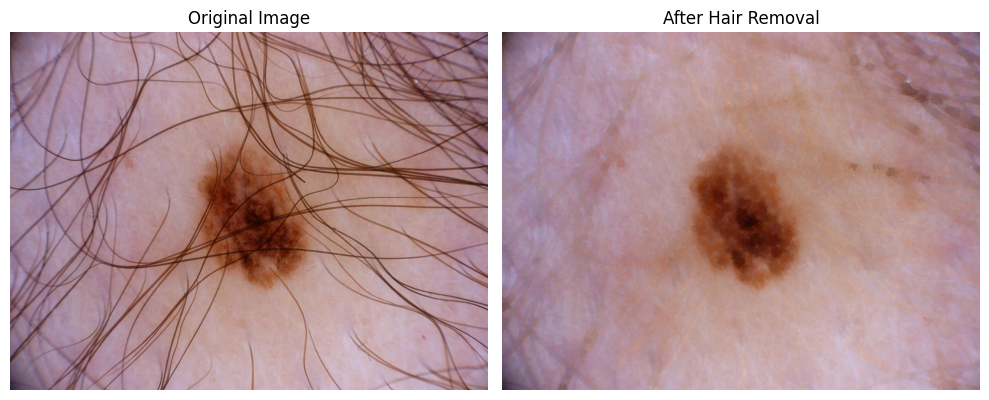

In [9]:
sample_image_path = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train/Melanocytic nevus/ISIC_0000095_downsampled.jpg'
original_img = Image.open(sample_image_path).convert('RGB')
hair_removed_img = remove_hair_opencv(original_img)

# # Show side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hair_removed_img)
plt.title("After Hair Removal")
plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
# Cell 7: Custom Transform for Hair Removal

class HairRemovalTransform(object):
    """
    Applies hair removal to a PIL image.
    """
    def __call__(self, img):
        return remove_hair_opencv(img)  # from Cell 5


In [11]:
# Cell 8: Data Transforms

train_transforms = transforms.Compose([
    HairRemovalTransform(),                # Hair Removal
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, 
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    HairRemovalTransform(),                # Same hair removal for test
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])


In [12]:
# Cell 9: Load Dataset

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

print("Classes:", train_dataset.classes)
print("Number of Training Images:", len(train_dataset))
print("Number of Validation/Test Images:", len(test_dataset))


Classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']
Number of Training Images: 697
Number of Validation/Test Images: 181


In [13]:
# Cell 10: Class Weights for Imbalanced Dataset

class_counts = [0] * len(train_dataset.classes)
for _, lbl in train_dataset:
    class_counts[lbl] += 1

class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[lbl] for _, lbl in train_dataset]

sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: [80, 81, 80, 80, 80, 80, 80, 56, 80]
Class Weights: tensor([0.0125, 0.0123, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0179, 0.0125])


In [14]:
# Cell 11: DataLoaders

batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler, 
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)


In [15]:
# Cell 12: Define and Modify ResNet18

resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 1. Freeze the first two layers to keep pre-trained features
for name, param in resnet18_model.named_parameters():
    if "layer1" in name or "layer2" in name:
        param.requires_grad = False

# 2. Add Dropout and adjust final FC for (e.g.) 9 classes
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),        # Increase dropout for regularization
    nn.Linear(num_ftrs, 9)    # Adjust to number of classes in your dataset
)

resnet18_model = resnet18_model.to(device)

print("✅ Modified ResNet18:\n", resnet18_model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s] 


✅ Modified ResNet18:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu):

In [16]:
# Cell 13: Define Loss and Optimizer (Constant LR)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=1e-4, weight_decay=1e-4)

print("🚀 Using Constant Learning Rate = 1e-4")


🚀 Using Constant Learning Rate = 1e-4


In [17]:
# Cell 14: Training Configuration & Loop

num_epochs = 50
best_val_acc = 0.0
best_model = copy.deepcopy(resnet18_model.state_dict())

# Metric Tracking
train_losses, val_losses = [], []
train_accs, val_accs = [], []
time_per_epoch = []

print("🚀 Starting ResNet18 Training for 50 Epochs with Constant Learning Rate...")

for epoch in range(num_epochs):
    start_time = time.time()
    
    ########################################
    # 🚦 Training Phase
    ########################################
    resnet18_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100.0 * correct / total
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    ########################################
    # 🧪 Validation Phase
    ########################################
    resnet18_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_acc = 100.0 * val_correct / val_total
    
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    epoch_time = time.time() - start_time
    time_per_epoch.append(epoch_time)
    
    # Print epoch summary
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | 🕒 Time: {epoch_time:.2f}s | "
          f"📉 Train Loss: {epoch_train_loss:.4f} | 📈 Train Acc: {epoch_train_acc:.2f}% | "
          f"📉 Val Loss: {epoch_val_loss:.4f} | 📈 Val Acc: {epoch_val_acc:.2f}% | "
          f"⚙️ LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Track best model based on val accuracy
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model = copy.deepcopy(resnet18_model.state_dict())

# Load the best model weights
resnet18_model.load_state_dict(best_model)
print(f"\n✅ Training complete! Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting ResNet18 Training for 50 Epochs with Constant Learning Rate...


Epoch 1/50: 100%|██████████| 44/44 [00:42<00:00,  1.02it/s]


📊 Epoch [1/50] | 🕒 Time: 53.59s | 📉 Train Loss: 1.6251 | 📈 Train Acc: 43.62% | 📉 Val Loss: 0.8468 | 📈 Val Acc: 67.96% | ⚙️ LR: 0.000100


Epoch 2/50: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]


📊 Epoch [2/50] | 🕒 Time: 51.04s | 📉 Train Loss: 0.8894 | 📈 Train Acc: 70.16% | 📉 Val Loss: 0.5767 | 📈 Val Acc: 76.24% | ⚙️ LR: 0.000100


Epoch 3/50: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]


📊 Epoch [3/50] | 🕒 Time: 51.00s | 📉 Train Loss: 0.7139 | 📈 Train Acc: 73.89% | 📉 Val Loss: 0.5754 | 📈 Val Acc: 77.90% | ⚙️ LR: 0.000100


Epoch 4/50: 100%|██████████| 44/44 [00:40<00:00,  1.10it/s]


📊 Epoch [4/50] | 🕒 Time: 49.42s | 📉 Train Loss: 0.5663 | 📈 Train Acc: 81.64% | 📉 Val Loss: 0.4781 | 📈 Val Acc: 79.01% | ⚙️ LR: 0.000100


Epoch 5/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [5/50] | 🕒 Time: 51.90s | 📉 Train Loss: 0.4295 | 📈 Train Acc: 86.80% | 📉 Val Loss: 0.4594 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 6/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


📊 Epoch [6/50] | 🕒 Time: 52.82s | 📉 Train Loss: 0.3911 | 📈 Train Acc: 88.09% | 📉 Val Loss: 0.4713 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 7/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [7/50] | 🕒 Time: 51.70s | 📉 Train Loss: 0.3659 | 📈 Train Acc: 87.66% | 📉 Val Loss: 0.4441 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 8/50: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]


📊 Epoch [8/50] | 🕒 Time: 51.13s | 📉 Train Loss: 0.3130 | 📈 Train Acc: 89.38% | 📉 Val Loss: 0.4834 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 9/50: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]


📊 Epoch [9/50] | 🕒 Time: 52.28s | 📉 Train Loss: 0.3082 | 📈 Train Acc: 88.95% | 📉 Val Loss: 0.5957 | 📈 Val Acc: 78.45% | ⚙️ LR: 0.000100


Epoch 10/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [10/50] | 🕒 Time: 51.44s | 📉 Train Loss: 0.2673 | 📈 Train Acc: 90.39% | 📉 Val Loss: 0.4507 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 11/50: 100%|██████████| 44/44 [00:42<00:00,  1.05it/s]


📊 Epoch [11/50] | 🕒 Time: 51.29s | 📉 Train Loss: 0.2124 | 📈 Train Acc: 93.54% | 📉 Val Loss: 0.4498 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 12/50: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


📊 Epoch [12/50] | 🕒 Time: 48.58s | 📉 Train Loss: 0.2411 | 📈 Train Acc: 91.82% | 📉 Val Loss: 0.4733 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 13/50: 100%|██████████| 44/44 [00:39<00:00,  1.10it/s]


📊 Epoch [13/50] | 🕒 Time: 49.01s | 📉 Train Loss: 0.2075 | 📈 Train Acc: 93.83% | 📉 Val Loss: 0.5809 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 14/50: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]


📊 Epoch [14/50] | 🕒 Time: 52.69s | 📉 Train Loss: 0.1800 | 📈 Train Acc: 94.26% | 📉 Val Loss: 0.4852 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 15/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [15/50] | 🕒 Time: 51.60s | 📉 Train Loss: 0.1826 | 📈 Train Acc: 94.12% | 📉 Val Loss: 0.4731 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 16/50: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]


📊 Epoch [16/50] | 🕒 Time: 50.72s | 📉 Train Loss: 0.1613 | 📈 Train Acc: 94.84% | 📉 Val Loss: 0.6564 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 17/50: 100%|██████████| 44/44 [00:40<00:00,  1.07it/s]


📊 Epoch [17/50] | 🕒 Time: 50.17s | 📉 Train Loss: 0.1707 | 📈 Train Acc: 93.83% | 📉 Val Loss: 0.5439 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100


Epoch 18/50: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]


📊 Epoch [18/50] | 🕒 Time: 50.55s | 📉 Train Loss: 0.1714 | 📈 Train Acc: 93.83% | 📉 Val Loss: 0.5971 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 19/50: 100%|██████████| 44/44 [00:39<00:00,  1.13it/s]


📊 Epoch [19/50] | 🕒 Time: 48.17s | 📉 Train Loss: 0.1474 | 📈 Train Acc: 95.98% | 📉 Val Loss: 0.5255 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 20/50: 100%|██████████| 44/44 [00:40<00:00,  1.08it/s]


📊 Epoch [20/50] | 🕒 Time: 49.66s | 📉 Train Loss: 0.1355 | 📈 Train Acc: 95.84% | 📉 Val Loss: 0.4698 | 📈 Val Acc: 86.19% | ⚙️ LR: 0.000100


Epoch 21/50: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]


📊 Epoch [21/50] | 🕒 Time: 52.19s | 📉 Train Loss: 0.0987 | 📈 Train Acc: 97.13% | 📉 Val Loss: 0.5819 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 22/50: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]


📊 Epoch [22/50] | 🕒 Time: 50.51s | 📉 Train Loss: 0.1047 | 📈 Train Acc: 97.27% | 📉 Val Loss: 0.4659 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 23/50: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]


📊 Epoch [23/50] | 🕒 Time: 50.67s | 📉 Train Loss: 0.1165 | 📈 Train Acc: 96.56% | 📉 Val Loss: 0.4813 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 24/50: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]


📊 Epoch [24/50] | 🕒 Time: 50.59s | 📉 Train Loss: 0.0846 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.5578 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 25/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [25/50] | 🕒 Time: 51.35s | 📉 Train Loss: 0.0983 | 📈 Train Acc: 97.70% | 📉 Val Loss: 0.6966 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 26/50: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]


📊 Epoch [26/50] | 🕒 Time: 51.22s | 📉 Train Loss: 0.0997 | 📈 Train Acc: 97.70% | 📉 Val Loss: 0.6953 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 27/50: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]


📊 Epoch [27/50] | 🕒 Time: 51.08s | 📉 Train Loss: 0.0737 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.6381 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 28/50: 100%|██████████| 44/44 [00:39<00:00,  1.10it/s]


📊 Epoch [28/50] | 🕒 Time: 49.03s | 📉 Train Loss: 0.0753 | 📈 Train Acc: 97.99% | 📉 Val Loss: 0.5834 | 📈 Val Acc: 86.19% | ⚙️ LR: 0.000100


Epoch 29/50: 100%|██████████| 44/44 [00:40<00:00,  1.09it/s]


📊 Epoch [29/50] | 🕒 Time: 49.51s | 📉 Train Loss: 0.0558 | 📈 Train Acc: 98.85% | 📉 Val Loss: 0.6304 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 30/50: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]


📊 Epoch [30/50] | 🕒 Time: 50.97s | 📉 Train Loss: 0.0669 | 📈 Train Acc: 97.99% | 📉 Val Loss: 0.6409 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 31/50: 100%|██████████| 44/44 [00:39<00:00,  1.13it/s]


📊 Epoch [31/50] | 🕒 Time: 48.34s | 📉 Train Loss: 0.0852 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.6595 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 32/50: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]


📊 Epoch [32/50] | 🕒 Time: 50.44s | 📉 Train Loss: 0.0842 | 📈 Train Acc: 97.99% | 📉 Val Loss: 0.7111 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 33/50: 100%|██████████| 44/44 [00:40<00:00,  1.09it/s]


📊 Epoch [33/50] | 🕒 Time: 49.71s | 📉 Train Loss: 0.0665 | 📈 Train Acc: 98.42% | 📉 Val Loss: 0.8313 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 34/50: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]


📊 Epoch [34/50] | 🕒 Time: 50.44s | 📉 Train Loss: 0.0703 | 📈 Train Acc: 97.56% | 📉 Val Loss: 0.7784 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 35/50: 100%|██████████| 44/44 [00:39<00:00,  1.13it/s]


📊 Epoch [35/50] | 🕒 Time: 48.08s | 📉 Train Loss: 0.0607 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.7372 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 36/50: 100%|██████████| 44/44 [00:40<00:00,  1.08it/s]


📊 Epoch [36/50] | 🕒 Time: 49.78s | 📉 Train Loss: 0.0641 | 📈 Train Acc: 97.70% | 📉 Val Loss: 0.5705 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 37/50: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]


📊 Epoch [37/50] | 🕒 Time: 50.37s | 📉 Train Loss: 0.0754 | 📈 Train Acc: 97.56% | 📉 Val Loss: 0.6452 | 📈 Val Acc: 86.74% | ⚙️ LR: 0.000100


Epoch 38/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [38/50] | 🕒 Time: 51.81s | 📉 Train Loss: 0.0515 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.7157 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 39/50: 100%|██████████| 44/44 [00:40<00:00,  1.09it/s]


📊 Epoch [39/50] | 🕒 Time: 49.48s | 📉 Train Loss: 0.0853 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.6669 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 40/50: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]


📊 Epoch [40/50] | 🕒 Time: 51.94s | 📉 Train Loss: 0.0708 | 📈 Train Acc: 97.99% | 📉 Val Loss: 0.6150 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 41/50: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]


📊 Epoch [41/50] | 🕒 Time: 50.70s | 📉 Train Loss: 0.0582 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.6583 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 42/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [42/50] | 🕒 Time: 51.23s | 📉 Train Loss: 0.0553 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.6104 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 43/50: 100%|██████████| 44/44 [00:39<00:00,  1.12it/s]


📊 Epoch [43/50] | 🕒 Time: 48.67s | 📉 Train Loss: 0.0409 | 📈 Train Acc: 99.00% | 📉 Val Loss: 0.6393 | 📈 Val Acc: 87.29% | ⚙️ LR: 0.000100


Epoch 44/50: 100%|██████████| 44/44 [00:40<00:00,  1.08it/s]


📊 Epoch [44/50] | 🕒 Time: 49.89s | 📉 Train Loss: 0.0659 | 📈 Train Acc: 98.42% | 📉 Val Loss: 0.5997 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 45/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [45/50] | 🕒 Time: 51.59s | 📉 Train Loss: 0.0471 | 📈 Train Acc: 99.00% | 📉 Val Loss: 0.6510 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 46/50: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]


📊 Epoch [46/50] | 🕒 Time: 50.18s | 📉 Train Loss: 0.0407 | 📈 Train Acc: 99.00% | 📉 Val Loss: 0.6124 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 47/50: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]


📊 Epoch [47/50] | 🕒 Time: 50.93s | 📉 Train Loss: 0.0592 | 📈 Train Acc: 98.13% | 📉 Val Loss: 0.6572 | 📈 Val Acc: 86.74% | ⚙️ LR: 0.000100


Epoch 48/50: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]


📊 Epoch [48/50] | 🕒 Time: 50.79s | 📉 Train Loss: 0.0384 | 📈 Train Acc: 98.57% | 📉 Val Loss: 0.7035 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 49/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


📊 Epoch [49/50] | 🕒 Time: 51.49s | 📉 Train Loss: 0.0398 | 📈 Train Acc: 98.85% | 📉 Val Loss: 0.7977 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 50/50: 100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


📊 Epoch [50/50] | 🕒 Time: 48.90s | 📉 Train Loss: 0.0379 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.6317 | 📈 Val Acc: 86.19% | ⚙️ LR: 0.000100

✅ Training complete! Best Validation Accuracy: 87.29%


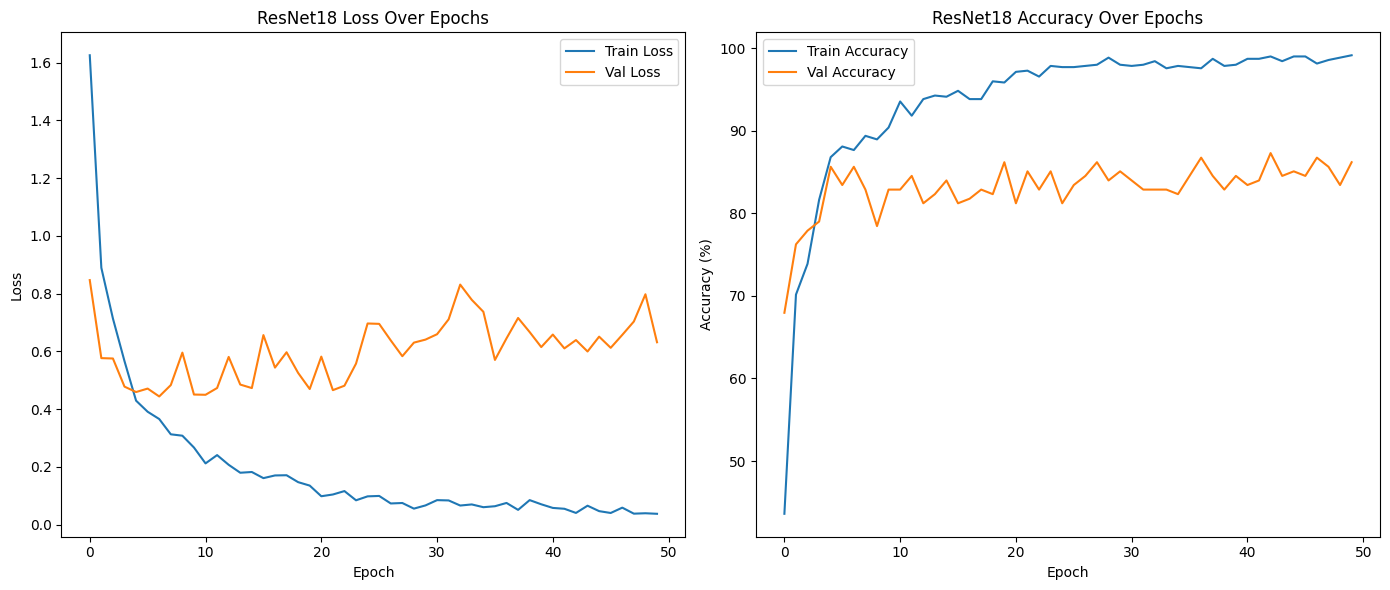

In [18]:
# Cell 15: Plot Loss and Accuracy Curves

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('ResNet18 Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('ResNet18 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


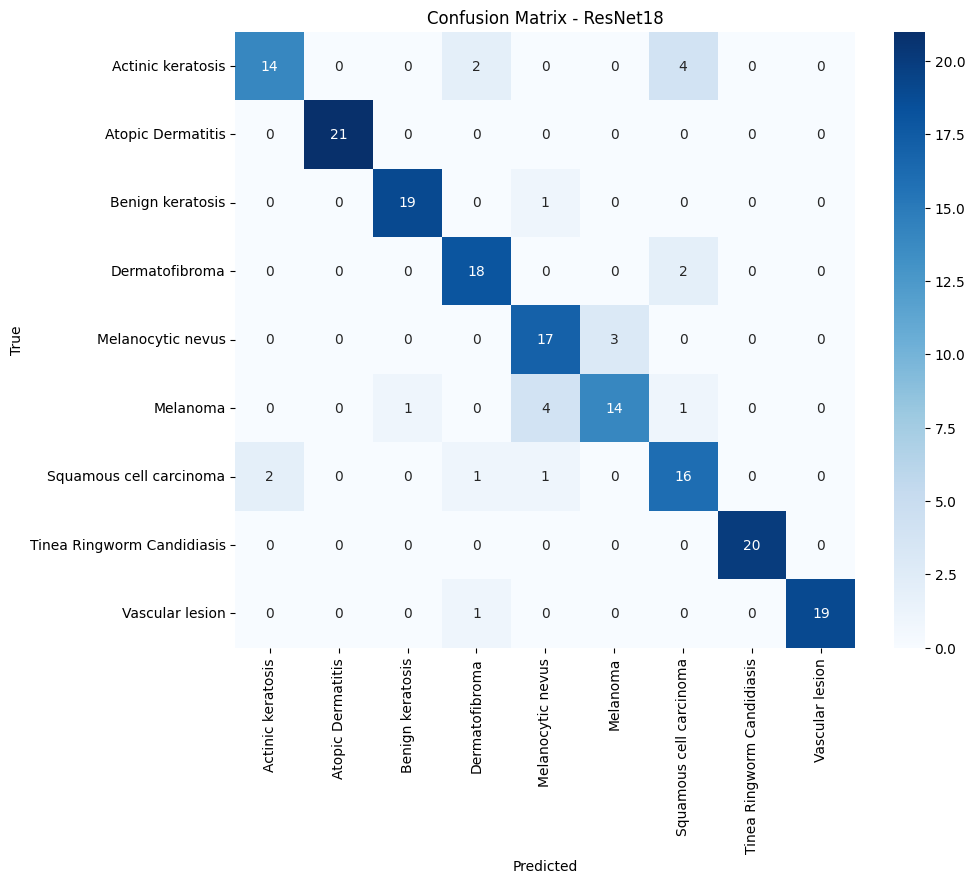


Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.88      0.70      0.78        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       0.95      0.95      0.95        20
            Dermatofibroma       0.82      0.90      0.86        20
         Melanocytic nevus       0.74      0.85      0.79        20
                  Melanoma       0.82      0.70      0.76        20
   Squamous cell carcinoma       0.70      0.80      0.74        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      0.95      0.97        20

                  accuracy                           0.87       181
                 macro avg       0.88      0.87      0.87       181
              weighted avg       0.88      0.87      0.87       181


✅ Overall Accuracy: 87.29%
Precision (Macro): 0.8779
Recall (Macro): 0.8722
F1-Score (Ma

In [19]:
# Cell 16: Final Evaluation on Test Set

resnet18_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - ResNet18")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Other Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"\n✅ Overall Accuracy: {acc*100:.2f}%")
print(f"Precision (Macro): {prec:.4f}")
print(f"Recall (Macro): {rec:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")
